In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
from io import StringIO
from utils import *
import sys
sys.path.append("/home/ubuntu/vdp-tool-chain-repo/utils")
from common import pz_partition, read_pickle, yolo_pzname_to_name
from train_clevr import VAE
from train_puzzles import PrototypeVAE
import itertools
from tqdm.auto import tqdm
device = torch.device("cuda:0")
# sns.set()

In [2]:
train_on = list(filter(lambda x: not x[1] , pz_partition.keys()))
images = VDPImage("../data/clevr-cleaned-variants", to_run)
# training_idxs = list(itertools.chain(*[list(range(l, h + 1)) for l, h in map(lambda x : pz_partition[x], train_on)]))
training_idxs = list(range(0, 825))
allpuzzles = torch.utils.data.Subset(images, training_idxs)
allpuzzles = DataLoader(allpuzzles, batch_size=1)



In [3]:
# set([os.path.basename(os.path.dirname(pth[0])) for (x, y, pth) in (allpuzzles)])


In [11]:
height = 320
model_str = f"again-cifar-puzzle-prototype-net-{height}-final"
model_vae = VAE(height).from_pretrained("cifar10-resnet18")
# model_vae = model_vae.load_from_checkpoint(f"../data/prototype/puzzle-pretrained-vae-320-final.ckpt", strict=False, input_height=height)
model = PrototypeVAE(model_vae)
model = model.load_from_checkpoint(f"../data/prototype/{model_str}.ckpt", strict=False, vae_model=model_vae)
model = model.to(device)

In [12]:
# with the vae pretraining

vae_preds = list()
tqdmiter = tqdm(allpuzzles)
for (x, y, pth) in tqdmiter:
    pred = model.forward_naive((x.to(device).squeeze(), y.to(device)))
    vae_preds.append((pth, y[0][pred.item()] == 0. ))
    # vae_preds.append((pth, torch.Tensor([True]) ))
    tqdmiter.set_description(f"Accuracy: {sum(map(lambda x: x[1], vae_preds) ) / len(vae_preds)}")

sum(map(lambda x: x[1], vae_preds) ) / len(vae_preds)

# 39.8 accuracy with old score
# 29.09 accuracy with new score


  0%|          | 0/825 [00:00<?, ?it/s]

tensor(0.3867)

In [13]:
cleaned_vae_preds = [(os.path.basename(os.path.dirname(x[0])), os.path.basename(x[0]), x[0], y.item()) for (x, y) in vae_preds]
with open(f"{model_str}-results.pkl", "wb") as fp:
    pickle.dump(cleaned_vae_preds, fp)

cleaned_vae_preds = read_pickle(f"{model_str}-results.pkl")

vae_df = pd.DataFrame(cleaned_vae_preds, columns=['puzzle_name', 'variant', 'pth', 'is_correct'])
vae_df['pth'] = vae_df['pth'].str.replace("../data", "data")

vae_df.head()

/home/ubuntu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


,puzzle_name,variant,pth,is_correct
0,agreement,fovariant-0,data/clevr-cleaned-variants/agreement/fovariant-0,True
1,agreement,fovariant-1,data/clevr-cleaned-variants/agreement/fovariant-1,True
2,agreement,fovariant-10,data/clevr-cleaned-variants/agreement/fovarian...,True
3,agreement,fovariant-11,data/clevr-cleaned-variants/agreement/fovarian...,True
4,agreement,fovariant-12,data/clevr-cleaned-variants/agreement/fovarian...,False


In [14]:

# preds = list()
# tqdmiter = tqdm(allpuzzles)
# for (x, y, pth) in tqdmiter:
#     pred = model.forward_naive((x.to(device).squeeze(), y.to(device)))
#     preds.append((pth, y[0][pred.item()] == 0. ))
#     # preds.append((pth, torch.Tensor([True]) ))
#     tqdmiter.set_description(f"Accuracy: {sum(map(lambda x: x[1], preds) ) / len(preds)}")

# sum(map(lambda x: x[1], preds) ) / len(preds)

# # $ 40.2 % before new loss

In [15]:
# cleaned_preds = [(os.path.basename(os.path.dirname(x[0])), os.path.basename(x[0]), x[0], y.item()) for (x, y) in preds]
# # with open(f"{model_str}-results.pkl", "wb") as fp:
# #     pickle.dump(cleaned_preds, fp)

# df = pd.DataFrame(cleaned_preds, columns=['puzzle_name', 'variant', 'pth', 'is_correct'])
# df['pth'] = df['pth'].str.replace("../data", "data")

# df.head()

In [16]:
with open("baseline_solver_preds.pkl", "rb") as fp:
    baseline_solver_preds = pickle.load(fp)
bs_df = pd.DataFrame(baseline_solver_preds, columns=["puzzle_name", "variant", "pth", "baseline", "solver"])
bs_df['baseline'] = (bs_df['baseline'] == 0)
bs_df['solver'] = (bs_df['solver'] == 0)
bs_df.head()

,puzzle_name,variant,pth,baseline,solver
0,apocope,fovariant-5-swap5,data/clevr-cleaned-variants/apocope/fovariant-...,False,True
1,apocope,fovariant-1,data/clevr-cleaned-variants/apocope/fovariant-1,False,True
2,apocope,fovariant-0,data/clevr-cleaned-variants/apocope/fovariant-0,True,True
3,apocope,fovariant-16-swap4,data/clevr-cleaned-variants/apocope/fovariant-...,False,True
4,apocope,fovariant-8,data/clevr-cleaned-variants/apocope/fovariant-8,True,True


In [17]:
results = vae_df.merge(bs_df, on='pth')

assert all(results['puzzle_name_x'] == results['puzzle_name_y'])
assert all(results['variant_x'] == results['variant_y'])

results['count'] = results.groupby(['puzzle_name_x'])['variant_x'].transform("count")
results['indexlabel'] = results.apply(lambda row: f"{row.name}", axis=1)
results['xlabel'] = results.apply(lambda row: f"{row['puzzle_name_x']}\n(N={row['count']})", axis=1)
results.groupby("puzzle_name_x")['is_correct'].count()


puzzle_name_x
agreement           25
alternate-color     25
alternation        100
aphaeresis          25
apocope             75
assimilation       100
breaking            50
circle-at-ends      50
devoicing           50
meeussen            25
partition           25
shield             100
spy                 75
threepack           50
train               50
Name: is_correct, dtype: int64

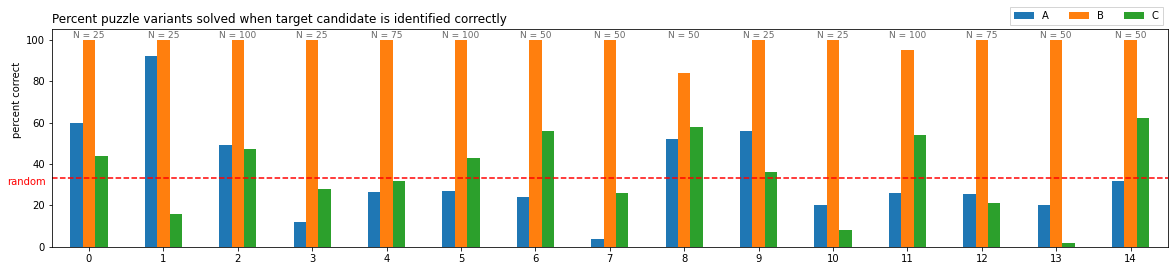

In [18]:
# sns.set()
result = results[['xlabel', 'count', 'indexlabel', 'variant_x', 'baseline', 'solver', 'is_correct']].rename(columns={
                                                                                    'xlabel':'puzzle_name',
                                                                                    'indexlabel' : 'pz_number',
                                                                                    'variant_x':'variant',
                                                                                    'is_correct':'C',
                                                                                    'count' : 'count',
                                                                                    'baseline':'A',
                                                                                    'solver':'B',
})


fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

barcont = (result.groupby(['puzzle_name'])[['A', 'B', 'C']].mean() * 100) .plot.bar(ax=ax)
ax.axhline(33.33, linestyle='--', color='red')
plt.text(-1.1, 31.33, "random", c="r", ha="left", va='center', alpha=1)
# ax.annotate('average',(-0.4,23.5))
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.125),
          ncol=3, fancybox=False, shadow=False)

# ax.set_xticklabels(result.groupby(['puzzle_name']).mean().index)

# bar1 = plt.bar(np.arange(len(errorRateListOfFast)) + bar_width, errorRateListOfFast, bar_width, align='center', alpha=opacity, color='b', label='Fast <= 6 sec.')

# Add counts above the two bar graphs
count_puzzles= result.groupby(['puzzle_name'])['count'].max().tolist()
max_height = max([rect.get_height() for rect in barcont.containers[1]])
for i, rect in enumerate(barcont.containers[1]):
    # height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, max_height, f'N = {count_puzzles[i]}', ha='center', va='bottom', c='dimgray', fontsize=9)



labels = list(map(lambda i : str(i), range(len(result.groupby(['puzzle_name']).mean().index))))
ax.set_xticklabels(labels)
plt.xticks(rotation=0, ha='center')

plt.xlabel(None)
plt.title("Percent puzzle variants solved when target candidate is identified correctly", loc='left')
plt.ylabel("percent correct", horizontalalignment='left')
plt.show()

In [19]:
natscene_df = pd.read_csv(StringIO("""puzzle| intended | unintended | incorrect
2on1| 53.0 | 11.333333333333343 | 35.666666666666664
allcatsonsofas| 36.0 | 18.333333333333343 | 45.666666666666664
alldogsonsofas| 14.583333333333334 | 68.75 | 16.666666666666668
catontv| 33.333333333333336 | 26.666666666666657 | 40.0
desktop| 95.33333333333333 | 4.666666666666671 | 0.0
dogherded| 88.75 | 11.25 | 0.0
kitchen| 45.5 | 17.5 | 37.0
parkmeter| 100.0 | 0.0 | 0.0
personball| 100.0 | 0.0 | 0.0
populatedbus| 55.0 | 20.0 | 25.0
pplwearingties| 28.333333333333332 | 19.33333333333333 | 52.333333333333336
sleeping| 71.66666666666667 | 11.666666666666657 | 16.666666666666668
umbrella| 52.083333333333336 | 12.916666666666657 | 35.0
separatepiles| 50.0 | 0.0 | 50.0
truck| 100.0 | 0.0 | 0.0
drivingdirection| 100.0 | 0.0 | 0.0
middleball| 10.0 | 0.0 | 90.0
allteddysonsofas| 87.33333333333333 | 12.666666666666671 | 0.0
setplates| 50.666666666666664 | 17.66666666666667 | 31.666666666666668
tvon| 0.0 | 0.3333333333333286 | 99.66666666666667"""), sep="|")

natscene_df['puzzle_name'] = natscene_df['puzzle'].map(yolo_pzname_to_name)


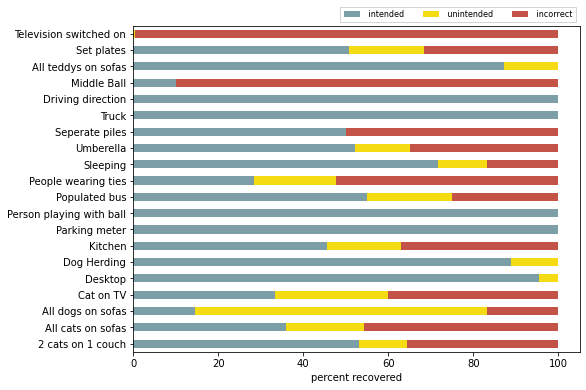

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
natscene_df.set_index('puzzle_name').plot(kind='barh', stacked=True, ax=ax, color=['#7B9EA7', '#F5DB11', '#C45347'])

ax.legend(loc='upper right', bbox_to_anchor=(1, 1.07),
          ncol=3, fancybox=False, shadow=False, prop=dict(size=8))


# labels = list(map(lambda i : str(i), range(len(natscene_df.index))))
# ax.set_xticklabels(labels,)
plt.xticks(rotation=0, ha='center')

plt.ylabel(None)
plt.xlabel("percent recovered")
# plt.show()
# sns.despine(left=False, bottom=False)
# plt.title("Title of this graph", loc='left')
# plt.ylabel("percent correct", horizontalalignment='left')
plt.show()

